In [100]:
import re
import random
import pandas as pd
import hashlib

In [101]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [102]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
SharePoint,137.857332,34.464333,42.288457,4
RAG Project,381.055937,23.815996,39.490207,16
Azure AD Authentication,604.218882,46.478376,107.076762,13
IW Migration,607.971187,75.996398,235.951358,8
Asynchronous Python,777.763810,16.907909,31.266861,46
Azure DevOps Pipelines,813.770001,31.298846,97.854591,26
Azure Functions + Visual Studio,867.398690,66.722976,270.589919,13
Email Auth and Security,899.614497,74.967875,188.927528,12
Open Source/GitHub,960.066825,60.004177,171.733032,16
Audit Report Tracker (Sharepoint List),1112.141601,92.678467,365.357725,12


# Histogram

sum of ages: ~41185.48


<Axes: >

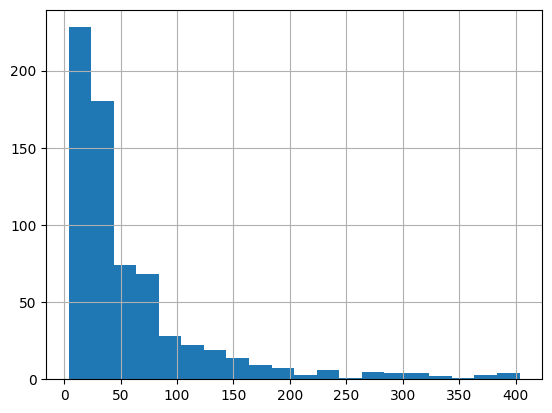

In [103]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [104]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [105]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [106]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [107]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [108]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [109]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [110]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [111]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [112]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 682
Total card age: 41185.48


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
0,Todd Ideas,"In Azure AI Document Intelligence, all custome...",36fb33cb29b1371aa7384d994d00a992,-395.978490,-115.424722,395.978490,1731.370827,0.219991,0,0
1,Todd Ideas,"In Azure AI Document Intelligence, Custom clas...",7c38d18ca290ac6d6cf9f31852bfe0c9,-159.218033,-115.424722,395.978490,1731.370827,0.219991,3,0
2,Todd Ideas,Connect Document Intelligence via REST APIs wi...,fa2f1bf88811e64ec380482f8e392f8e,-81.257136,-115.424722,395.978490,1731.370827,0.219991,6,0
466,Todd Ideas,"In Azure AI Document Intelligence, the incomin...",25bee331381996e961fa4e6bf8bc58b9,-43.042081,-115.424722,395.978490,1731.370827,0.219991,9,0
4,Todd Ideas,"In Azure AI Document Intelligence, prebuilt Do...",4e0c4117f3b9e489fb2df88cb22891ba,-27.290859,-115.424722,395.978490,1731.370827,0.219991,12,0
5,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-374.725314,-100.304132,374.725314,3510.644633,0.333016,0,0
6,Logging in Python,Q: What is the advantage of using logging.getL...,e63d3ef375f4f0905315b7f337ed7eff,-274.563719,-100.304132,374.725314,3510.644633,0.333016,3,0
7,Logging in Python,Q: How can you include exception tracebacks in...,6a344b1ab62495533fc42ded0c61a8d8,-159.989271,-100.304132,374.725314,3510.644633,0.333016,6,0
470,Logging in Python,Q: Why might you choose to use Loguru over Pyt...,eef062671a42262fab39291ccdda1e48,-137.885789,-100.304132,374.725314,3510.644633,0.333016,9,0
9,Logging in Python,Q: How can external log rotation tools like lo...,57b27fed5d075e5af65bbc29bdfdbaa4,-126.266051,-100.304132,374.725314,3510.644633,0.333016,12,0


## Age Max

In [113]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# # existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [114]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [115]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [116]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
124,Azure Developer Associate,What must be configured on Application Gateway...,8ddf39df1182f81ce6e58790da23ef19,-403.581667,-61.142655,403.581667,4279.985820,0.104591,0,0
148,PnP PowerShell,Server Relative URL\nThe URL path relative to ...,8cf299b28aba8eeb49c675bc6fd23204,-400.273024,-47.532698,400.273024,3422.354285,0.591026,0,0
0,Todd Ideas,"In Azure AI Document Intelligence, all custome...",36fb33cb29b1371aa7384d994d00a992,-395.978490,-115.424722,395.978490,1731.370827,0.219991,0,0
48,Debugging in VS Code,Debugger API\nAn application programming inter...,379ed80170d7da4e8ca2e7b1a4b9527c,-392.205979,-74.474227,392.205979,1415.010322,0.324318,0,0
379,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-377.743793,-47.532698,400.273024,3422.354285,0.591026,1,1
5,Logging in Python,Q: How can you configure Python's logging to o...,293e680688510b291b7b3691786112ec,-374.725314,-100.304132,374.725314,3510.644633,0.333016,0,0
30,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,-365.357725,-92.678467,365.357725,1112.141601,0.210199,0,0
356,Azure Developer Associate,Q: Which tiers of Azure Cache for Redis are ba...,1dfb97906449c201f5bdfcd75cba1819,-346.272502,-61.142655,403.581667,4279.985820,0.104591,1,1
599,PnP PowerShell,AppInv.aspx\nA SharePoint page used to grant a...,ffb4c4ea52b6951b0ba17c6ec30a0956,-329.484450,-47.532698,400.273024,3422.354285,0.591026,2,2
55,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-329.059455,-72.024369,329.059455,3817.291579,0.320046,0,0


In [117]:
existing_cards.head(10).sum()

head                   Todd IdeasTodd IdeasTodd IdeasTodd IdeasTodd I...
body                   In Azure AI Document Intelligence, all custome...
hash                   36fb33cb29b1371aa7384d994d00a9927c38d18ca290ac...
age                                                         -1780.216743
subject_mean_age                                            -1078.644271
subject_highest_age                                          3853.519019
subject_age_sum                                             26210.077301
head_random_roll                                                2.765038
count                                                                 60
n_fold                                                                 0
dtype: object

In [118]:
existing_cards['age'].mean()

-60.38926424879886